## Studying the bell curve effect.

We wish to investigate if we observe the bell shape, with respect to mem loss, and the difference between mem and gen loss. 

In [8]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random

# diffusionlab imports
from diffusionlab.dynamics import VariancePreservingProcess
from diffusionlab.losses import DiffusionLoss
from diffusionlab.vector_fields import VectorFieldType

# repo imports
from investigating_diffusion_loss import AmbientDiffusionLoss
from src.diffusion_mem_gen.models.gmm import (
    IsoHomGMMInitStrategy,
    iso_hom_gmm_create_initialization_parameters,
    IsoHomGMMSharedParametersEstimator,
)
from src.diffusion_mem_gen.utils.factories import compute_loss_factory

# Set random key
key = random.PRNGKey(0)

In [9]:
# Diffusion process
diffusion_process = VariancePreservingProcess()

# Model parameters
laboratory_d = 32 * 32  # data dimension
laboratory_N = 300  # number of training samples
laboratory_K = 40  # number of components in the GMM

u_means_variance = 0.06 ** (1/2)  # controls the variance of the means
sample_variance = 0.06  # isotropic variance for each component

# Time grid for evaluation
t_val_array = jnp.linspace(0.01, 0.99, 26)

In [10]:
# Generate ground-truth GMM and training data
key, sk = random.split(key)
true_means = random.normal(sk, (laboratory_K, laboratory_d)) * u_means_variance
equal_weighted_prior = jnp.array([1/laboratory_K for _ in range(laboratory_K)])

# Sample training set from the true GMM
key, sk = random.split(key)
comp_ids = random.choice(sk, laboratory_K, shape=(laboratory_N,), p=equal_weighted_prior)
key, sk = random.split(key)
X_train = true_means[comp_ids] + jnp.sqrt(sample_variance) * random.normal(sk, (laboratory_N, laboratory_d))

In [ ]:
# Check that the min distance between the means is order d, and the max modulus is order d.

from scipy.spatial.distance import pdist
import numpy as np

# Calculate all pairwise distances between the means
pairwise_dists = pdist(true_means)
min_dist = np.min(pairwise_dists)

# Calculate the maximum modulus (maximum Euclidean norm from origin)
max_modulus = np.max(np.linalg.norm(true_means, axis=1))

print(f"Minimum distance between means: {min_dist:.3f} (should be ~O(d) == {laboratory_d})")
print(f"Maximum modulus of any mean: {max_modulus:.3f} (should be ~O(d) == {laboratory_d})")

In [11]:
# Build MEM denoiser (uses training points as memorised means)
key, sk = random.split(key)
context = {
    "X_train": X_train,
    "init_var_scale": 1e-10,
    "init_means_noise_var": 0.0,
}
means_mem, var_mem, priors_mem = iso_hom_gmm_create_initialization_parameters(
    sk, IsoHomGMMInitStrategy.PMEM, laboratory_d, laboratory_N, context
)
mem_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_N,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=means_mem,
    init_var=var_mem,
    priors=priors_mem,
)

# Build Generalising denoiser
generalising_model = IsoHomGMMSharedParametersEstimator(
    dim=laboratory_d,
    num_components=laboratory_K,
    vf_type=VectorFieldType.X0,
    diffusion_process=diffusion_process,
    init_means=true_means,
    init_var=jnp.asarray(sample_variance),
    priors=equal_weighted_prior,
)

C:\Users\chris\AppData\Local\Temp\ipykernel_12396\3853611868.py:11: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  mem_model = IsoHomGMMSharedParametersEstimator(
C:\Users\chris\AppData\Local\Temp\ipykernel_12396\3853611868.py:22: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  generalising_model = IsoHomGMMSharedParametersEstimator(


In [12]:
# Create standard loss object once (reused for all computations)
standard_loss_obj = DiffusionLoss(
    diffusion_process, 
    vector_field_type=VectorFieldType.X0, 
    num_noise_draws_per_sample=1
)

def L_N_t(key, model_callable, t_val_array, t_n_value, X_0_dataset, X_t_n_dataset, lambda_fn):
    """
    Compute the total loss L_N_t for a given model.
    
    This function computes the loss by splitting the time array into:
    - Standard denoising: t <= t_n
    - Ambient denoising: t > t_n
    
    Optimizations:
    - Reuses the standard loss object
    - Uses efficient JAX operations
    - The compute_loss functions from compute_loss_factory already use JAX internally
      and will benefit from JAX's automatic optimization
    
    Returns the total loss.
    """
    # Create ambient loss object for this t_n_value
    ambient_loss_obj = AmbientDiffusionLoss(
        diffusion_process, 
        num_noise_draws_per_sample=1, 
        t_n=t_n_value
    )
    
    # Split time array into standard and ambient denoising regions
    less_than_n_mask = t_val_array <= t_n_value
    greater_than_n_mask = ~less_than_n_mask
    
    standard_denoising_t_values = t_val_array[less_than_n_mask]
    ambient_denoising_t_values = t_val_array[greater_than_n_mask]
    
    total_loss = 0.0
    
    # Compute standard denoising losses (t <= t_n)
    if len(standard_denoising_t_values) > 0:
        keys = random.split(key, len(standard_denoising_t_values))
        standard_losses = []
        for k, t in zip(keys, standard_denoising_t_values):
            compute_loss = compute_loss_factory(standard_loss_obj, t)
            loss_val = compute_loss(k, model_callable, X_0_dataset) / X_0_dataset.shape[0]
            standard_losses.append(lambda_fn(t) * loss_val)
        total_loss += jnp.mean(jnp.array(standard_losses))
    
    # Compute ambient denoising losses (t > t_n)
    if len(ambient_denoising_t_values) > 0:
        keys = random.split(key, len(ambient_denoising_t_values))
        ambient_losses = []
        for k, t in zip(keys, ambient_denoising_t_values):
            compute_loss = compute_loss_factory(ambient_loss_obj, t)
            loss_val = compute_loss(k, model_callable, X_t_n_dataset) / X_t_n_dataset.shape[0]
            ambient_losses.append(lambda_fn(t) * loss_val)
        total_loss += jnp.mean(jnp.array(ambient_losses))
    
    return total_loss

In [13]:
# Lambda function (weight function) - uniform weighting
lambda_fn = lambda t: 1.0

# Range of t_n values to investigate
t_n_values = jnp.linspace(0.1, 0.9, 17)  # 17 values from 0.1 to 0.9

# Pre-generate X_t_n datasets for each t_n value
batch_diffusion_forward = jax.vmap(
    diffusion_process.forward, in_axes=(0, None, 0)
)

X_t_n_datasets = {}
for t_n in t_n_values:
    key, subk = random.split(key)
    X_t_n_eps = random.normal(subk, X_train.shape)
    X_t_n_datasets[float(t_n)] = batch_diffusion_forward(X_train, t_n, X_t_n_eps)

In [14]:
# Compute losses for memorising and generalising models across different t_n values
mem_losses = []
gen_losses = []

print("Computing losses...")
for i, t_n in enumerate(t_n_values):
    t_n_float = float(t_n)
    X_t_n_dataset = X_t_n_datasets[t_n_float]
    
    # Compute memorising model loss
    key, subk = random.split(key)
    mem_loss = L_N_t(
        subk, mem_model, t_val_array, t_n, X_train, X_t_n_dataset, lambda_fn
    )
    mem_losses.append(float(mem_loss))
    
    # Compute generalising model loss
    key, subk = random.split(key)
    gen_loss = L_N_t(
        subk, generalising_model, t_val_array, t_n, X_train, X_t_n_dataset, lambda_fn
    )
    gen_losses.append(float(gen_loss))
    
    if (i + 1) % 5 == 0:
        print(f"Completed {i + 1}/{len(t_n_values)} t_n values")

mem_losses = jnp.array(mem_losses)
gen_losses = jnp.array(gen_losses)
loss_difference = mem_losses - gen_losses

Computing losses...
Completed 5/17 t_n values
Completed 10/17 t_n values
Completed 15/17 t_n values


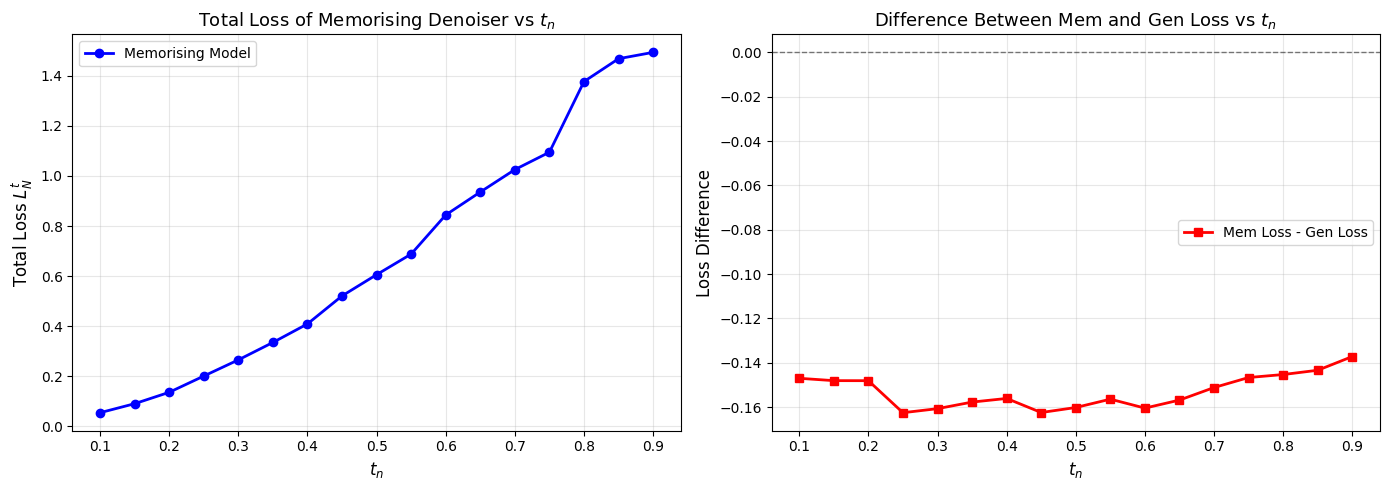

In [15]:
# Plot 1: Total loss L_N_t of memorising denoiser vs t_n
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(t_n_values, mem_losses, 'o-', linewidth=2, markersize=6, color='blue', label='Memorising Model')
ax1.set_xlabel('$t_n$', fontsize=12)
ax1.set_ylabel('Total Loss $L_N^t$', fontsize=12)
ax1.set_title('Total Loss of Memorising Denoiser vs $t_n$', fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

ax2 = axes[1]
ax2.plot(t_n_values, loss_difference, 's-', linewidth=2, markersize=6, color='red', label='Mem Loss - Gen Loss')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('$t_n$', fontsize=12)
ax2.set_ylabel('Loss Difference', fontsize=12)
ax2.set_title('Difference Between Mem and Gen Loss vs $t_n$', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

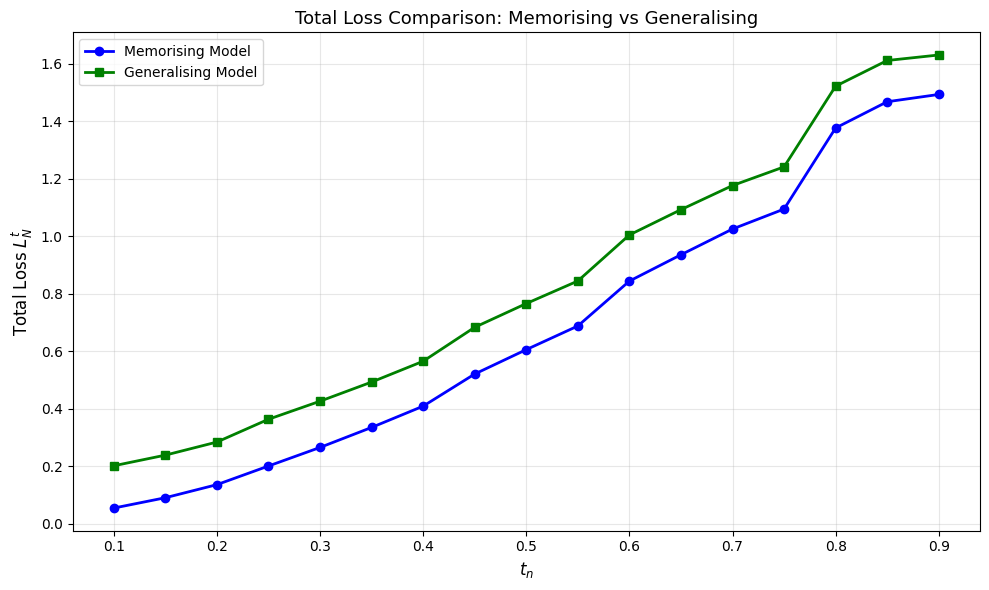


Summary Statistics:
Mem loss range: [0.0550, 1.4930]
Gen loss range: [0.2020, 1.6301]
Loss difference range: [-0.1625, -0.1372]


In [16]:
# Combined plot showing both memorising and generalising losses
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(t_n_values, mem_losses, 'o-', linewidth=2, markersize=6, color='blue', label='Memorising Model')
ax.plot(t_n_values, gen_losses, 's-', linewidth=2, markersize=6, color='green', label='Generalising Model')
ax.set_xlabel('$t_n$', fontsize=12)
ax.set_ylabel('Total Loss $L_N^t$', fontsize=12)
ax.set_title('Total Loss Comparison: Memorising vs Generalising', fontsize=13)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nSummary Statistics:")
print(f"Mem loss range: [{mem_losses.min():.4f}, {mem_losses.max():.4f}]")
print(f"Gen loss range: [{gen_losses.min():.4f}, {gen_losses.max():.4f}]")
print(f"Loss difference range: [{loss_difference.min():.4f}, {loss_difference.max():.4f}]")